# What is the 20-80 scouting scale?
While a lot of things in baseball have changed in recent years, some have stayed exactly the same. Baseball scouts have used the 20-80 scale to evaluate players tools for decades. The idea behind the scale is that a score of 50 indicates league average. These *grades* apply to both tools and an overall scouting grade for each player. Furthermore, player evaluators will typically assign a player a *current* value and a *future* value, hence the name of the recent book on the subject by Eric Longenhagen and Kiley McDaniel.

The question we pose cuts a little deeper however. In this post, we'll describe in detail the 20-80 scale and how we can use Statcast data to define the scale for several tools. In addition, we'll investigate how much scouting can be done from behind a computer vs. actually being present at games to see players in live action.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../../blog_posts/statcast_pitches_2019.csv')

## Hitter Tools
The main tools that are evaluated for position player prospects (i.e. hitters) are contact (or hit), power, speed, arm strength, and ??. Power is especially significant in today's game, as the home run has been identified as the single most impactful result a hitter can have. Thus, power is typically evaluated a two seperate tools: *raw power* and *game power*. We've previously discussed the relationship of *launch angle* and *exit velocity* with hitting home runs. The measure for *raw power* is the maximum exit velocity that a hitter can generate. So let's look at the player tier for maximum exit velocity in 2019 using Statcast data.

In [5]:
dfGroupedMaxEV = df.groupby(['batter']).max()
#dfGroupedMaxEV['launch_speed'].hist(bins=25)
dfGroupedMaxEV_.hist(bins=25)

NameError: name 'dfGroupedMaxEV_' is not defined

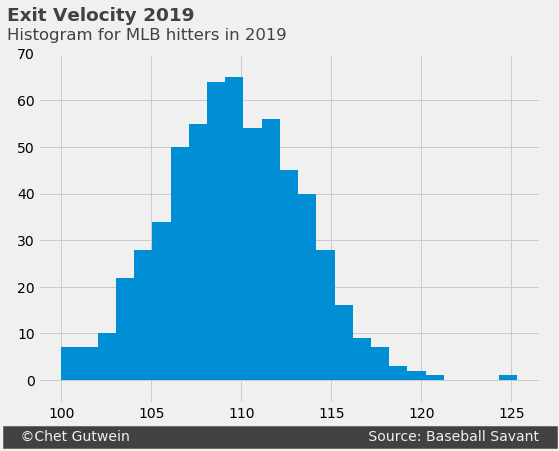

In [28]:
# Bar chart - launch angle by result 
# Setting FiveThirtyEight style
plt.style.use('fivethirtyeight')

# Setting size of our plot
fig, ax = plt.subplots(figsize=(8,6))

ax1 = dfGroupedMaxEV_.hist(bins=25)

# Y axis past 0 & above 100 -- grid line will pass 0 & 100 marker
plt.ylim(-5,70)

# Bolded horizontal line at y=0
#ax1.axhline(y=0, color='#414141', linewidth=1.5, alpha=.5)

# Y-labels to only these
#ax.set_yticks([0, 10000,20000, 30000, 40000])
#ax.set_yticklabels(labels=['0', '10000', '20000', '30000', '40000'], fontsize=14, color='#414141')

# X-labels and changing label names
#ax.set_xticklabels(['Out', 'Single', 'Double', 'Triple','Homer'],fontsize=14, color='#414141')

# Title text
ax.text(x=97, y=77, s="Exit Velocity 2019", fontsize=18.5, fontweight='semibold', color='#414141')

# Subtitle text
ax.text(x=97, y=73, s='Histogram for MLB hitters in 2019', fontsize=16.5, color='#414141')

ax.set_ylabel('')    
ax.set_xlabel('')

# legend
#ax.legend(["< 10 degree launch angle", "> 10 degree launch angle"], loc=7)

# Line at bottom for signature line
ax1.text(x = 97, y = -13,
    s = '   ©Chet Gutwein                                                     Source: Baseball Savant   ',
    fontsize = 14, color = '#f0f0f0', backgroundcolor = '#414141');

plt.savefig('ev_2019_hist.png')

Above we have the plotted histogram of maximum exit velocity from a hitter in 2019. Please note that we have filtered results to include only maximum launch speeds greater than or equal to 100 mph because there are so few results lower than 100. Also, results for pitchers are filtered out as well. Calculating the 20-80 scale is really quite easy. We'll use the mean, $\mu$ and the standard deviation, $\sigma$ to determine the range for each grade in raw power based on a player's maximum exit velocity.

In [8]:
dfGroupedMaxEV_ = dfGroupedMaxEV[(dfGroupedMaxEV['launch_speed'] >=100) & (dfGroupedMaxEV['POS'] != "P")]['launch_speed']
mu = int(dfGroupedMaxEV_.mean())
sigma = int(dfGroupedMaxEV_.std())
print(mu, sigma)

109 3


The average maximum exit velocity generated by a player is 109 mph with a standard deviation of 3 mph. Applying the principles of the 20-80 scale, this makes a player with a maximum of 112 mph a 60 and a player with a 106 mph a 40. We'll make use of interpolation to map a hitter's maximum exit velocity to their **raw power** grade on the 20-80 scale.

In [9]:
from scipy.interpolate import interp1d
scaled = interp1d([mu-3*sigma, mu+3*sigma], [20,80], bounds_error=False, fill_value=20)
scaled(mu)

array(50.)

In [10]:
EV_grades = dfGroupedMaxEV_.apply(scaled)

In [11]:
EV_grades.max()

80.0

In [12]:
dfGroupedMaxEV['EV_grade'] = EV_grades

In [3]:
## loading player Id map, use PLAYERNAME and 
df_ids = pd.read_csv('../../mlb/data/PLAYERIDMAP.csv')
id_list = list(df_ids['MLBID'])

def get_player_name(pid, ref="MLB"):
    ref_dict = {
        "MLB": "MLBID"
    }
    
    rid = ref_dict[ref]
    id_list = list(df_ids[rid])
    if pid not in id_list:
        batter_name = '--'
        pos = '--'
    else:
        batter_name = df_ids[df_ids[rid] == pid]['PLAYERNAME'].values[0]
        pos = df_ids[df_ids[rid] == pid]['POS'].values[0]
    return(batter_name, pos)

get_player_name(282332)

('CC Sabathia', 'P')

In [5]:
get_player_name(282332)[0]

'CC Sabathia'

In [7]:
hitter_ids = dfGroupedMaxEV.index
#dfGroupedMaxEV['batter_name'] = hitter_ids.apply()
dfGroupedMaxEV['batter_name'] = pd.Series({x: get_player_name(x)[0] for x in dfGroupedMaxEV.index})
dfGroupedMaxEV['POS'] = pd.Series({x: get_player_name(x)[1] for x in dfGroupedMaxEV.index})
#pd.Series(index.map(myfunc), name=index.name)

In [14]:
dfGroupedMaxEV[['batter_name', 'POS','launch_speed', 'EV_grade']].head(6).to_html(buf='./table1.html',index=False)

### Max EV Table
We ran the 80-20 scale for maximum exit velocity in the 2019 MLB season, here is the range with some random player examples for each category.

In [15]:
from pynverse import inversefunc
from numpy import random

def make_8020_table(scoutField, valField, df):
    """
    Create an html table summarizing 80-20 scale.
    
    Inputs:
    1: scoutField: string of column name for scouting grade value,
    2: valField: string of column name for measurable value,
    3: df: dataframe of players
    
    Outputs:
    1: html_table: string containing html code for table summarizing as follows
    
    
    | Scouting Grade | Cutpoint Value | Example players |
    ...
    
    """
    dict_8020 = dict()
    for grade in [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]:
        l = grade - 2.5
        u = grade + 2.5
        df_sub = df[(df[scoutField] >= l) & (df[scoutField] < u)]
        if len(df_sub) >= 2:
            #print(l, u, len(df_sub))
            cut = df_sub[valField].min()
            players = random.choice(df_sub['batter_name'], size=2, replace=False)
            p1 = players[0] + "(" + str(df_sub[df_sub['batter_name'] == players[0]][valField].values[0]) + ")"
            p2 = players[1] + "(" + str(df_sub[df_sub['batter_name'] == players[1]][valField].values[0]) + ")"
            dict_8020[grade] = {'Scouting Grade': grade, 'Cutpoint Value': cut, 'Example Players': p1+ ", " + p2}
    df_8020 = pd.DataFrame.from_dict(dict_8020, orient='index').sort_values('Scouting Grade', ascending=False)
    df_8020 = df_8020[['Scouting Grade', 'Cutpoint Value', 'Example Players']]
    
    return(df_8020.to_html(buf='./table2.html',index=False))

In [16]:
make_8020_table('EV_grade', 'launch_speed', dfGroupedMaxEV)
#EV_table

In [22]:
for p in ['Nolan Arenado', 'Charlie Blackmon', 'Trevor Story']:
    ev = dfGroupedMaxEV[dfGroupedMaxEV['batter_name'] == p]['EV_grade'].values[0]
    print(p, ev)

Nolan Arenado 53.00000000000002
Charlie Blackmon 55.99999999999999
Trevor Story 59.33333333333333
